In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import json
from matplotlib import pyplot as plt
import torch 
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import trange, tqdm
import seaborn as sns 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
n_channels=2
batch_size=64
frame_size = 128 
n_labels = 6 # adjust how many modulation need to train
# Number of frames per snr/modulation combination for train,valid and test data
nf_train = 1024
nf_valid = 512
nf_test = 256

In [4]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.7, #set 70% from dataset as train 
                  valid_proportion=0.2, #Set 20 % from dataset as valid 
                  test_proportion=0.1, # set 10 % as tetsing 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [5]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str,seed=48,):
        super(RadioML18Dataset, self).__init__()
                                                              
        # load data
        hdf5_file = h5py.File("/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5",  'r')
        self.modulation_classes = json.load(open("/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/classes-fixed.json", 'r'))
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]
        
        train_proportion=(24*26*nf_train)/self.X.shape[0]
        valid_proportion=(24*26*nf_valid)/self.X.shape[0]
        test_proportion=(24*26*nf_test)/self.X.shape[0]
        
        """target_modulations =['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK',
        '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']target 
        modulation class and snr"""   

        # in this line i could change it the target modulation 
        self.target_modulations =['BPSK', 'QPSK', '8PSK',
        '16QAM','32QAM','64QAM'] #Let's try only 4 modulation 

        self.target_snrs = np.unique(self.Z)
        
        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )   

        # store statistic of whole dataset
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        x,y,z = torch.Tensor(x).transpose(0, 1) , y , z
        return x,y,z

In [6]:
ds = RadioML18Dataset(mode='test')
data_len = ds.num_data
n_labels=ds.num_lbl
n_snrs = ds.num_snr
frame_size=ds.X.shape[1]

del ds

In [7]:
dataset = RadioML18Dataset(mode='train')

# Print all modulation classes
print("All Modulation Classes:", dataset.modulation_classes)

All Modulation Classes: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [8]:
import time 
st = time.time() 
train_dl = DataLoader(dataset=RadioML18Dataset(mode='train'),batch_size = 64, shuffle = True, drop_last = True)
valid_dl = DataLoader(dataset=RadioML18Dataset(mode='valid'),batch_size = 128, shuffle = True, drop_last = False) 
test_dl = DataLoader(dataset=RadioML18Dataset(mode='train'), batch_size = 128, shuffle = True, drop_last = False) 
et = time.time() 
elapsed_time = et - st 
print(f'Execution time : {elapsed_time} second') 

Execution time : 15.050369262695312 second


# CNN Architecture with Modular Blocks in PyTorch

This notebook defines a convolutional neural network (CNN) using modular blocks. 
Each block consists of a convolution, batch normalization, activation, pooling, and dropout layer. 
The final architecture includes a classifier head with fully connected layers.


In [9]:
class CNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.25)
        )

    def forward(self, x):
        return self.block(x)

# Define the full CNN network
class CNN_NET(nn.Module):
    def __init__(self, n_labels):
        super().__init__()
        self.backbone = nn.Sequential(
            CNN_Block(2, 32),
            CNN_Block(32, 64),
            CNN_Block(64, 128),
            CNN_Block(128, 128),
            nn.AdaptiveAvgPool1d(8)  # Fixed-size output
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_labels)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

In [10]:
model = CNN_NET(n_labels).to('cuda')

# Safer: create explicit dummy input
dummy_input = torch.randn(1, n_channels, frame_size).to('cuda')

summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_NET                                  [1, 6]                    --
├─Sequential: 1-1                        [1, 128, 8]               --
│    └─CNN_Block: 2-1                    [1, 32, 512]              --
│    │    └─Sequential: 3-1              [1, 32, 512]              288
│    └─CNN_Block: 2-2                    [1, 64, 256]              --
│    │    └─Sequential: 3-2              [1, 64, 256]              6,336
│    └─CNN_Block: 2-3                    [1, 128, 128]             --
│    │    └─Sequential: 3-3              [1, 128, 128]             24,960
│    └─CNN_Block: 2-4                    [1, 128, 64]              --
│    │    └─Sequential: 3-4              [1, 128, 64]              49,536
│    └─AdaptiveAvgPool1d: 2-5            [1, 128, 8]               --
├─Sequential: 1-2                        [1, 6]                    --
│    └─Flatten: 2-6                      [1, 1024]                 --
│  

In [11]:
def train_model(model, verbose=True, device='cuda', num_epoch=50):
    model.to(device)

    train_loss = torch.zeros(num_epoch)
    train_acc = torch.zeros(num_epoch)
    val_loss = torch.zeros(num_epoch)
    val_acc = torch.zeros(num_epoch)

    lr = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=3e-4)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in trange(num_epoch, desc='epochs'):
        # ----- Training Phase -----
        model.train()
        total_train_loss, total_train_correct, total_train_samples = 0.0, 0, 0

        for x, y, _ in train_dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x.size(0)
            total_train_correct += (logits.argmax(dim=1) == y).sum().item()
            total_train_samples += x.size(0)

        train_loss[epoch] = total_train_loss / total_train_samples
        train_acc[epoch] = total_train_correct / total_train_samples

        # ----- Validation Phase -----
        model.eval()
        total_val_loss, total_val_correct, total_val_samples = 0.0, 0, 0

        with torch.no_grad():
            for x, y, _ in valid_dl:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                total_val_loss += loss.item() * x.size(0)
                total_val_correct += (logits.argmax(dim=1) == y).sum().item()
                total_val_samples += x.size(0)

        val_loss[epoch] = total_val_loss / total_val_samples
        val_acc[epoch] = total_val_correct / total_val_samples

        # Update learning rate
        lr_scheduler.step()

        # Optional verbose output
        if verbose:
            tqdm.write(f"Epoch {epoch+1:02d} | Train Loss: {train_loss[epoch]:.4f}, Acc: {train_acc[epoch]:.4f}")
            tqdm.write(f"           | Val   Loss: {val_loss[epoch]:.4f}, Acc: {val_acc[epoch]:.4f}")

    # Pack history into a dictionary
    train_history = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
    }

    return model, train_history


In [16]:
def test_model_with_improved_plots(model, device='cuda'):
    model.eval()
    Y_pred_ = []  # Predictions
    Y_true_ = []  # Ground truth
    Z_snr_ = []   # SNR values
    
    target_classes = test_dl.dataset.target_modulations
    target_snrs = test_dl.dataset.target_snrs
    modulation_classes = test_dl.dataset.modulation_classes
    target_modulations_indices = [modulation_classes.index(mod) for mod in target_classes]

    # Add debug 
    print(f"target modulation:{target_classes}") 
    print(f"target SNR: {target_snrs}") 
    
    # Initialize accuracy stats DataFrame
    accuracy_stats = pd.DataFrame(
        0.0,
        index=target_classes,
        columns=target_snrs.astype('str'))
    
    # Get predictions with tqdm progress bar
    test_loader = tqdm(test_dl, desc="Testing model", leave=True)
    
    with torch.no_grad():
        for x, y, z in test_loader:
            # Move tensors to specified device
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            
            # Get model predictions on device
            logits = model(x)
            y_pred = torch.argmax(logits, dim=-1)
            
            # Store results
            Y_pred_.append(y_pred.cpu())  # Move back to CPU for storage
            Y_true_.append(y.cpu())
            Z_snr_.append(z.cpu())
            
            # Free up memory
            del x, y, z, logits, y_pred
            torch.cuda.empty_cache() if device == 'cuda' else None
    
    # Convert to numpy for easier processing
    Y_pred = torch.cat(Y_pred_).numpy()
    Y_true = torch.cat(Y_true_).numpy()
    Z_snr = torch.cat(Z_snr_).numpy()
    
    # Clear lists to free memory
    del Y_pred_, Y_true_, Z_snr_
    
    # Calculate overall accuracy
    correct_preds = (Y_pred == Y_true).sum()
    total_samples = len(Y_true)
    total_accuracy = round(correct_preds * 100 / total_samples, 2)
    print(f'Accuracy on test dataset: {total_accuracy}%')

    # Count samples for each modulation type 
    mod_counts = {}  # Define mod_counts dictionary here
    for mod_idx, mod_name in enumerate(target_classes): 
        count = np.sum(Y_true == mod_idx) 
        mod_counts[mod_name] = count
        print(f"Modulation {mod_name}: {count} test samples")
    
    # Calculate accuracy per modulation and SNR with progress bar
    mod_snr_progress = tqdm(list(enumerate(target_classes)), 
                           desc="Calculating per-modulation accuracies",
                           leave=True)
    
    for mod_idx, mod_name in mod_snr_progress:
        mod_snr_progress.set_postfix({"modulation": mod_name})
        for snr_idx, snr in enumerate(target_snrs):
            snr_str = str(snr)

            mask = (Y_true == mod_idx) & (Z_snr == snr)
            total_samples = mask.sum() 
            if total_samples > 0: 
                correct_samples = ((Y_pred == Y_true) & mask).sum()
                accuracy = (correct_samples * 100 / total_samples)
                accuracy_stats.loc[mod_name, snr_str] = round(accuracy, 2) 
            else: 
                accuracy_stats.loc[mod_name, snr_str] = np.nan 
                print(f"Warning: no samples for {mod_name} at SNR = {snr}")

    return accuracy_stats, mod_counts, Y_true, Y_pred   # Return mod_counts too

def plot_improved_test_accuracy(model, device='cuda'): 
    """
    Improved plotting function that shows all modulations properly 
    """
    accuracy_df, mod_counts, _, _ = test_model_with_improved_plots(model, device)

    plt.figure(figsize=(14, 8)) 

    accuracy_long = accuracy_df.reset_index().melt(  # Fixed typo: mel -> melt
        id_vars=['index'],
        var_name='SNR',
        value_name='Accuracy'
    )
    accuracy_long.columns = ['Modulation', 'SNR', 'Accuracy']

    sns.lineplot(
        data=accuracy_long,
        x='SNR',
        y='Accuracy',
        hue='Modulation', 
        marker='o',
        markersize=8, 
        linewidth=2
    )

    # Specifically highlights PSK modulations 
    psk_mods = [mod for mod in accuracy_df.index if 'PSK' in mod]
    if psk_mods:
        print(f"Highlighting PSK modulation: {psk_mods}") 
        psk_df = accuracy_long[accuracy_long['Modulation'].isin(psk_mods)]

        for mod in psk_mods: 
            mod_data = psk_df[psk_df['Modulation'] == mod] 
            plt.plot(mod_data['SNR'], mod_data['Accuracy'], 
                     linewidth=3.5,
                     linestyle='--',
                     marker='*',
                     markersize=12)
            
    plt.title('Classification Accuracy vs SNR for Different Modulation Types', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('all_modulations_accuracy.png', dpi=300)
    plt.show()  

    n_rows = (len(accuracy_df.index) + 2) // 3 

    fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows*4), sharey=True) 
    axes = axes.flatten() 

    for i in range(len(accuracy_df.index), len(axes)): 
        axes[i].set_visible(False) 

    for i, mod in enumerate(accuracy_df.index): 
        ax = axes[i] 

        mod_data = accuracy_df.loc[mod].astype(float)  # Fixed typo: astype[float] -> astype(float)

        ax.bar(mod_data.index, mod_data.values, color='skyblue' if 'PSK' not in mod else 'red')  # Fixed typo: mode_data -> mod_data

        ax.plot(mod_data.index, mod_data.values, 'k--', linewidth=2) 

        ax.set_title(f'{mod}', fontsize=14)
        ax.set_xlabel('SNR (dB)' if i >= len(accuracy_df.index) - 3 else '')
        ax.set_ylabel('Accuracy (%)' if i % 3 == 0 else '')
        ax.set_ylim(0, 105)  # Set y-axis from 0 to 100% with a bit of margin
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.suptitle('Classification Accuracy by Modulation Type', fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for suptitle
    plt.savefig('modulation_accuracy_subplots.png', dpi=300)
    plt.show()
    
    # 3. Also create a heatmap visualization
    plt.figure(figsize=(14, 8))
    sns.heatmap(accuracy_df.astype(float), annot=True, cmap='viridis', fmt='.1f', 
                cbar_kws={'label': 'Accuracy (%)'})
    plt.title('Classification Accuracy Heatmap by Modulation and SNR', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Modulation Type', fontsize=14)
    plt.tight_layout()
    plt.savefig('modulation_accuracy_heatmap.png', dpi=300)
    plt.show()
    
    return accuracy_df
    
def plot_training_history(model_name, history):
    plt.figure(figsize=(10, 6))
    plt.title(f'Training of {model_name} model on radioml2018')
    plt.xlabel('Epochs')   

    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['train_acc'], label='train_accuracy')
    plt.plot(history['val_loss'], label='valid_loss')
    plt.plot(history['val_acc'], label='valid_accuracy')

    plt.legend(loc="upper left")
    plt.savefig(f'{model_name}_training_history.png', dpi=300)
    plt.show()

def check_dataset_distribution(test_dl):
    """
    Analyze the distribution of modulations in the dataset
    """
    # Get dataset
    dataset = test_dl.dataset
    
    # Analyze distribution
    mod_counts = {}
    snr_mod_counts = {}
    
    # Initialize counts for all modulations
    for mod in dataset.target_modulations:
        mod_counts[mod] = 0
    
    # Set up progress bar
    progress_bar = tqdm(range(len(dataset)), desc="Analyzing dataset", leave=True)
    
    # Count occurrences of each modulation
    for i in progress_bar:
        _, mod_idx, snr = dataset[i]
        mod = dataset.target_modulations[mod_idx]
        
        # Count by modulation
        mod_counts[mod] += 1
        
        # Count by modulation and SNR
        if snr not in snr_mod_counts:
            snr_mod_counts[snr] = {}
        if mod not in snr_mod_counts[snr]:
            snr_mod_counts[snr][mod] = 0
        snr_mod_counts[snr][mod] += 1
        
        # Update progress bar with current modulation
        if i % 100 == 0:  # Update less frequently to improve performance
            progress_bar.set_postfix({"current_mod": mod, "snr": snr})
    
    print("Modulation distribution in dataset:")
    for mod, count in mod_counts.items():
        print(f"  {mod}: {count} samples")
    
    # Special check for PSK modulations
    psk_mods = [mod for mod in dataset.target_modulations if 'PSK' in mod]
    print("\nPSK modulation distribution:")
    for mod in psk_mods:
        print(f"\n{mod} distribution across SNRs:")
        for snr in sorted(snr_mod_counts.keys()):
            count = snr_mod_counts[snr].get(mod, 0)
            print(f"  SNR {snr}dB: {count} samples")
    
    return mod_counts, snr_mod_counts

def improved_train_test_plots(model, model_name, verbose = True,device='cuda', num_epoch=30):
    # First check the dataset distribution
    print("Analyzing test dataset distribution...")
    mod_counts, snr_mod_counts = check_dataset_distribution(test_dl)
    
    # Train the model with tqdm progress
    print(f"\nTraining {model_name}...")
    model, train_history = train_model(model, verbose=verbose, device=device, num_epoch=num_epoch)
    torch.save(model, f'{model_name}.pth')
    
    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(model_name, train_history)  # Changed to pass model_name instead of model
    
    # Plot test accuracy with improved visualization
    print("\nEvaluating and plotting test accuracy...")
    accuracy_results = plot_improved_test_accuracy(model, device)
    
    return model, train_history, accuracy_results

Analyzing test dataset distribution...


Analyzing dataset: 100%|█| 159744/15


Modulation distribution in dataset:
  BPSK: 26624 samples
  QPSK: 26624 samples
  8PSK: 26624 samples
  16QAM: 26624 samples
  32QAM: 26624 samples
  64QAM: 26624 samples

PSK modulation distribution:

BPSK distribution across SNRs:
  SNR -20dB: 1024 samples
  SNR -18dB: 1024 samples
  SNR -16dB: 1024 samples
  SNR -14dB: 1024 samples
  SNR -12dB: 1024 samples
  SNR -10dB: 1024 samples
  SNR -8dB: 1024 samples
  SNR -6dB: 1024 samples
  SNR -4dB: 1024 samples
  SNR -2dB: 1024 samples
  SNR 0dB: 1024 samples
  SNR 2dB: 1024 samples
  SNR 4dB: 1024 samples
  SNR 6dB: 1024 samples
  SNR 8dB: 1024 samples
  SNR 10dB: 1024 samples
  SNR 12dB: 1024 samples
  SNR 14dB: 1024 samples
  SNR 16dB: 1024 samples
  SNR 18dB: 1024 samples
  SNR 20dB: 1024 samples
  SNR 22dB: 1024 samples
  SNR 24dB: 1024 samples
  SNR 26dB: 1024 samples
  SNR 28dB: 1024 samples
  SNR 30dB: 1024 samples

QPSK distribution across SNRs:
  SNR -20dB: 1024 samples
  SNR -18dB: 1024 samples
  SNR -16dB: 1024 samples
  SNR 

epochs:   2%| | 1/50 [00:36<29:29, 3

Epoch 01 | Train Loss: 1.0781, Acc: 0.4833
           | Val   Loss: 0.9429, Acc: 0.5676


epochs:   4%| | 2/50 [01:20<32:43, 4

Epoch 02 | Train Loss: 0.9313, Acc: 0.5765
           | Val   Loss: 0.9957, Acc: 0.5488


epochs:   6%| | 3/50 [02:08<34:38, 4

Epoch 03 | Train Loss: 0.8990, Acc: 0.5938
           | Val   Loss: 0.9184, Acc: 0.5898


epochs:   8%| | 4/50 [02:58<35:33, 4

Epoch 04 | Train Loss: 0.8533, Acc: 0.6195
           | Val   Loss: 0.8957, Acc: 0.6047


epochs:  10%| | 5/50 [03:49<36:00, 4

Epoch 05 | Train Loss: 0.8327, Acc: 0.6262
           | Val   Loss: 0.8784, Acc: 0.6144


epochs:  12%| | 6/50 [04:40<36:00, 4

Epoch 06 | Train Loss: 0.8195, Acc: 0.6326
           | Val   Loss: 0.8781, Acc: 0.6152


epochs:  14%|▏| 7/50 [05:31<35:37, 4

Epoch 07 | Train Loss: 0.8100, Acc: 0.6360
           | Val   Loss: 0.9209, Acc: 0.5941


epochs:  16%|▏| 8/50 [06:22<35:12, 5

Epoch 08 | Train Loss: 0.8032, Acc: 0.6401
           | Val   Loss: 0.9834, Acc: 0.5810


epochs:  18%|▏| 9/50 [07:14<34:35, 5

Epoch 09 | Train Loss: 0.7994, Acc: 0.6394
           | Val   Loss: 0.8934, Acc: 0.6133


epochs:  20%|▏| 10/50 [08:05<33:50, 

Epoch 10 | Train Loss: 0.7936, Acc: 0.6429
           | Val   Loss: 1.0783, Acc: 0.5346


epochs:  22%|▏| 11/50 [08:57<33:12, 

Epoch 11 | Train Loss: 0.7873, Acc: 0.6450
           | Val   Loss: 1.2065, Acc: 0.5006


epochs:  24%|▏| 12/50 [09:50<32:46, 

Epoch 12 | Train Loss: 0.7836, Acc: 0.6469
           | Val   Loss: 1.1292, Acc: 0.5364


epochs:  26%|▎| 13/50 [10:42<32:02, 

Epoch 13 | Train Loss: 0.7790, Acc: 0.6500
           | Val   Loss: 1.1110, Acc: 0.5368


epochs:  28%|▎| 14/50 [11:34<31:10, 

Epoch 14 | Train Loss: 0.7756, Acc: 0.6505
           | Val   Loss: 1.0788, Acc: 0.5453


epochs:  30%|▎| 15/50 [12:27<30:31, 

Epoch 15 | Train Loss: 0.7720, Acc: 0.6524
           | Val   Loss: 1.0524, Acc: 0.5475


epochs:  32%|▎| 16/50 [13:20<29:41, 

Epoch 16 | Train Loss: 0.7710, Acc: 0.6529
           | Val   Loss: 0.9593, Acc: 0.5847


epochs:  34%|▎| 17/50 [14:13<28:50, 

Epoch 17 | Train Loss: 0.7678, Acc: 0.6556
           | Val   Loss: 1.0844, Acc: 0.5364


epochs:  36%|▎| 18/50 [15:05<27:58, 

Epoch 18 | Train Loss: 0.7636, Acc: 0.6566
           | Val   Loss: 1.0356, Acc: 0.5550


epochs:  38%|▍| 19/50 [15:57<26:57, 

Epoch 19 | Train Loss: 0.7603, Acc: 0.6582
           | Val   Loss: 1.0744, Acc: 0.5535


epochs:  40%|▍| 20/50 [16:48<26:01, 

Epoch 20 | Train Loss: 0.7583, Acc: 0.6592
           | Val   Loss: 1.0984, Acc: 0.5362


epochs:  42%|▍| 21/50 [17:41<25:16, 

Epoch 21 | Train Loss: 0.7555, Acc: 0.6599
           | Val   Loss: 1.0680, Acc: 0.5481


epochs:  44%|▍| 22/50 [18:34<24:28, 

Epoch 22 | Train Loss: 0.7540, Acc: 0.6599
           | Val   Loss: 1.0479, Acc: 0.5500


epochs:  46%|▍| 23/50 [19:26<23:31, 

Epoch 23 | Train Loss: 0.7523, Acc: 0.6618
           | Val   Loss: 1.1448, Acc: 0.5240


epochs:  48%|▍| 24/50 [20:18<22:39, 

Epoch 24 | Train Loss: 0.7508, Acc: 0.6623
           | Val   Loss: 1.1041, Acc: 0.5370


epochs:  50%|▌| 25/50 [21:10<21:41, 

Epoch 25 | Train Loss: 0.7487, Acc: 0.6627
           | Val   Loss: 1.1904, Acc: 0.5068


epochs:  52%|▌| 26/50 [22:02<20:48, 

Epoch 26 | Train Loss: 0.7479, Acc: 0.6631
           | Val   Loss: 1.0608, Acc: 0.5504


epochs:  54%|▌| 27/50 [22:53<19:54, 

Epoch 27 | Train Loss: 0.7453, Acc: 0.6655
           | Val   Loss: 0.9840, Acc: 0.5723


epochs:  56%|▌| 28/50 [23:45<19:01, 

Epoch 28 | Train Loss: 0.7450, Acc: 0.6637
           | Val   Loss: 1.1571, Acc: 0.5174


epochs:  58%|▌| 29/50 [24:37<18:11, 

Epoch 29 | Train Loss: 0.7428, Acc: 0.6656
           | Val   Loss: 1.0728, Acc: 0.5429


epochs:  60%|▌| 30/50 [25:30<17:23, 

Epoch 30 | Train Loss: 0.7411, Acc: 0.6666
           | Val   Loss: 1.1165, Acc: 0.5321


epochs:  62%|▌| 31/50 [26:23<16:36, 

Epoch 31 | Train Loss: 0.7410, Acc: 0.6667
           | Val   Loss: 1.1353, Acc: 0.5277


epochs:  64%|▋| 32/50 [27:16<15:45, 

Epoch 32 | Train Loss: 0.7409, Acc: 0.6664
           | Val   Loss: 1.1369, Acc: 0.5281


epochs:  66%|▋| 33/50 [28:09<14:55, 

Epoch 33 | Train Loss: 0.7393, Acc: 0.6662
           | Val   Loss: 1.2150, Acc: 0.5175


epochs:  68%|▋| 34/50 [29:05<14:19, 

Epoch 34 | Train Loss: 0.7372, Acc: 0.6683
           | Val   Loss: 1.0787, Acc: 0.5423


epochs:  70%|▋| 35/50 [30:00<13:33, 

Epoch 35 | Train Loss: 0.7365, Acc: 0.6686
           | Val   Loss: 1.0392, Acc: 0.5533


epochs:  72%|▋| 36/50 [30:54<12:38, 

Epoch 36 | Train Loss: 0.7367, Acc: 0.6681
           | Val   Loss: 1.0007, Acc: 0.5668


epochs:  74%|▋| 37/50 [31:48<11:41, 

Epoch 37 | Train Loss: 0.7370, Acc: 0.6683
           | Val   Loss: 1.0113, Acc: 0.5595


epochs:  76%|▊| 38/50 [32:41<10:43, 

Epoch 38 | Train Loss: 0.7356, Acc: 0.6699
           | Val   Loss: 1.0496, Acc: 0.5529


epochs:  78%|▊| 39/50 [33:33<09:45, 

Epoch 39 | Train Loss: 0.7350, Acc: 0.6696
           | Val   Loss: 1.0549, Acc: 0.5488


epochs:  80%|▊| 40/50 [34:26<08:50, 

Epoch 40 | Train Loss: 0.7351, Acc: 0.6693
           | Val   Loss: 1.0464, Acc: 0.5576


epochs:  82%|▊| 41/50 [35:20<07:59, 

Epoch 41 | Train Loss: 0.7346, Acc: 0.6693
           | Val   Loss: 1.0587, Acc: 0.5503


epochs:  84%|▊| 42/50 [36:12<07:05, 

Epoch 42 | Train Loss: 0.7349, Acc: 0.6695
           | Val   Loss: 1.0478, Acc: 0.5515


epochs:  86%|▊| 43/50 [37:05<06:10, 

Epoch 43 | Train Loss: 0.7333, Acc: 0.6698
           | Val   Loss: 1.0458, Acc: 0.5537


epochs:  88%|▉| 44/50 [37:58<05:18, 

Epoch 44 | Train Loss: 0.7345, Acc: 0.6694
           | Val   Loss: 1.0431, Acc: 0.5536


epochs:  90%|▉| 45/50 [38:52<04:26, 

Epoch 45 | Train Loss: 0.7330, Acc: 0.6701
           | Val   Loss: 1.0756, Acc: 0.5456


epochs:  92%|▉| 46/50 [39:46<03:34, 

Epoch 46 | Train Loss: 0.7327, Acc: 0.6705
           | Val   Loss: 1.0374, Acc: 0.5553


epochs:  94%|▉| 47/50 [40:42<02:42, 

Epoch 47 | Train Loss: 0.7328, Acc: 0.6710
           | Val   Loss: 1.0815, Acc: 0.5424


epochs:  96%|▉| 48/50 [41:36<01:48, 

Epoch 48 | Train Loss: 0.7328, Acc: 0.6708
           | Val   Loss: 1.0092, Acc: 0.5652


epochs:  98%|▉| 49/50 [42:30<00:54, 

Epoch 49 | Train Loss: 0.7330, Acc: 0.6702
           | Val   Loss: 1.0692, Acc: 0.5471


epochs: 100%|█| 50/50 [43:25<00:00, 


Epoch 50 | Train Loss: 0.7325, Acc: 0.6711
           | Val   Loss: 1.0421, Acc: 0.5537

Plotting training history...


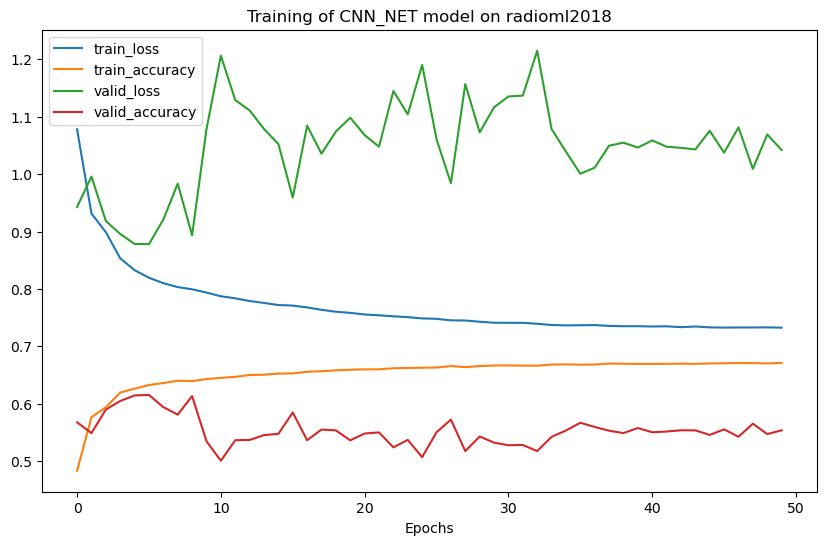


Evaluating and plotting test accuracy...
target modulation:['BPSK', 'QPSK', '8PSK', '16QAM', '32QAM', '64QAM']
target SNR: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]


Testing model: 100%|█| 1248/1248 [00


Accuracy on test dataset: 56.1%
Modulation BPSK: 26624 test samples
Modulation QPSK: 26624 test samples
Modulation 8PSK: 26624 test samples
Modulation 16QAM: 26624 test samples
Modulation 32QAM: 26624 test samples
Modulation 64QAM: 26624 test samples


Calculating per-modulation accuracie


Highlighting PSK modulation: ['BPSK', 'QPSK', '8PSK']


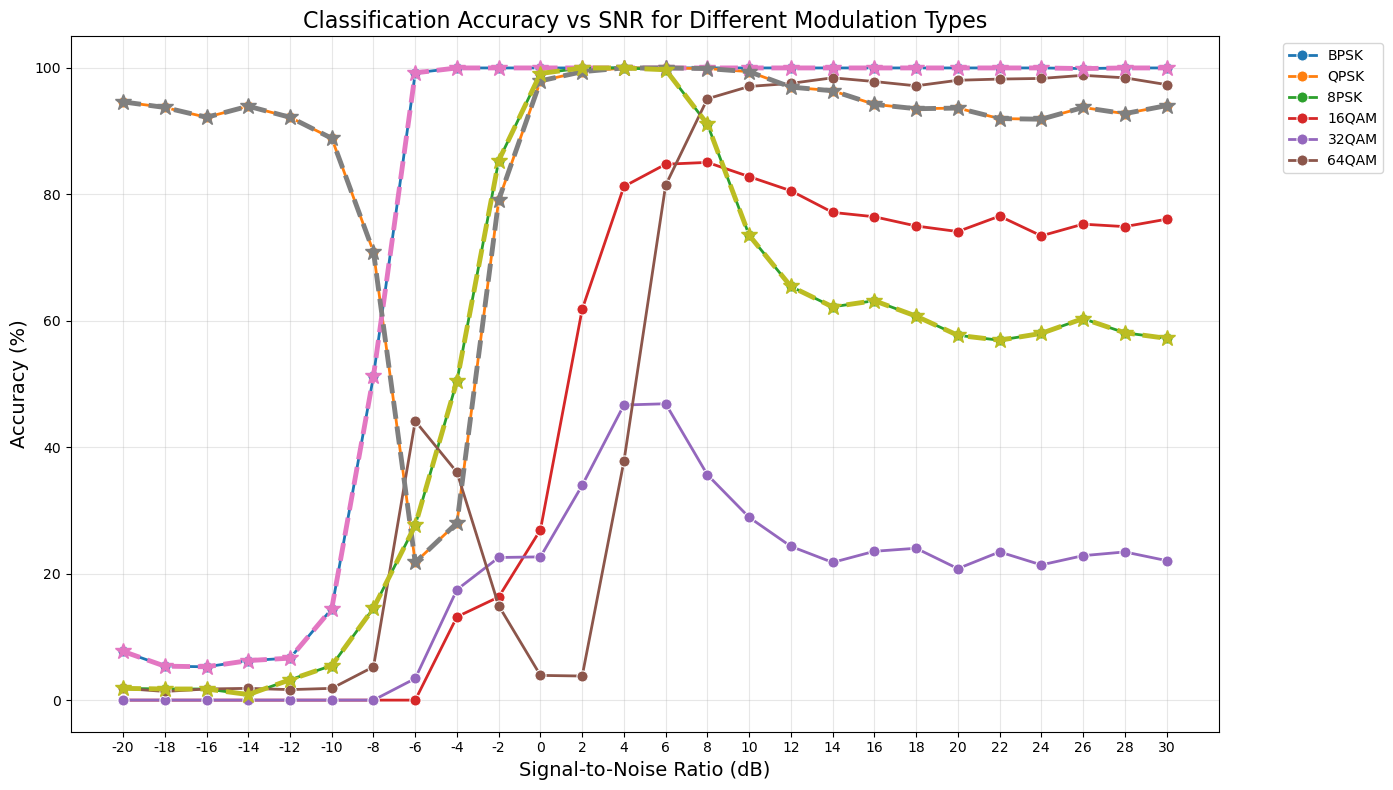

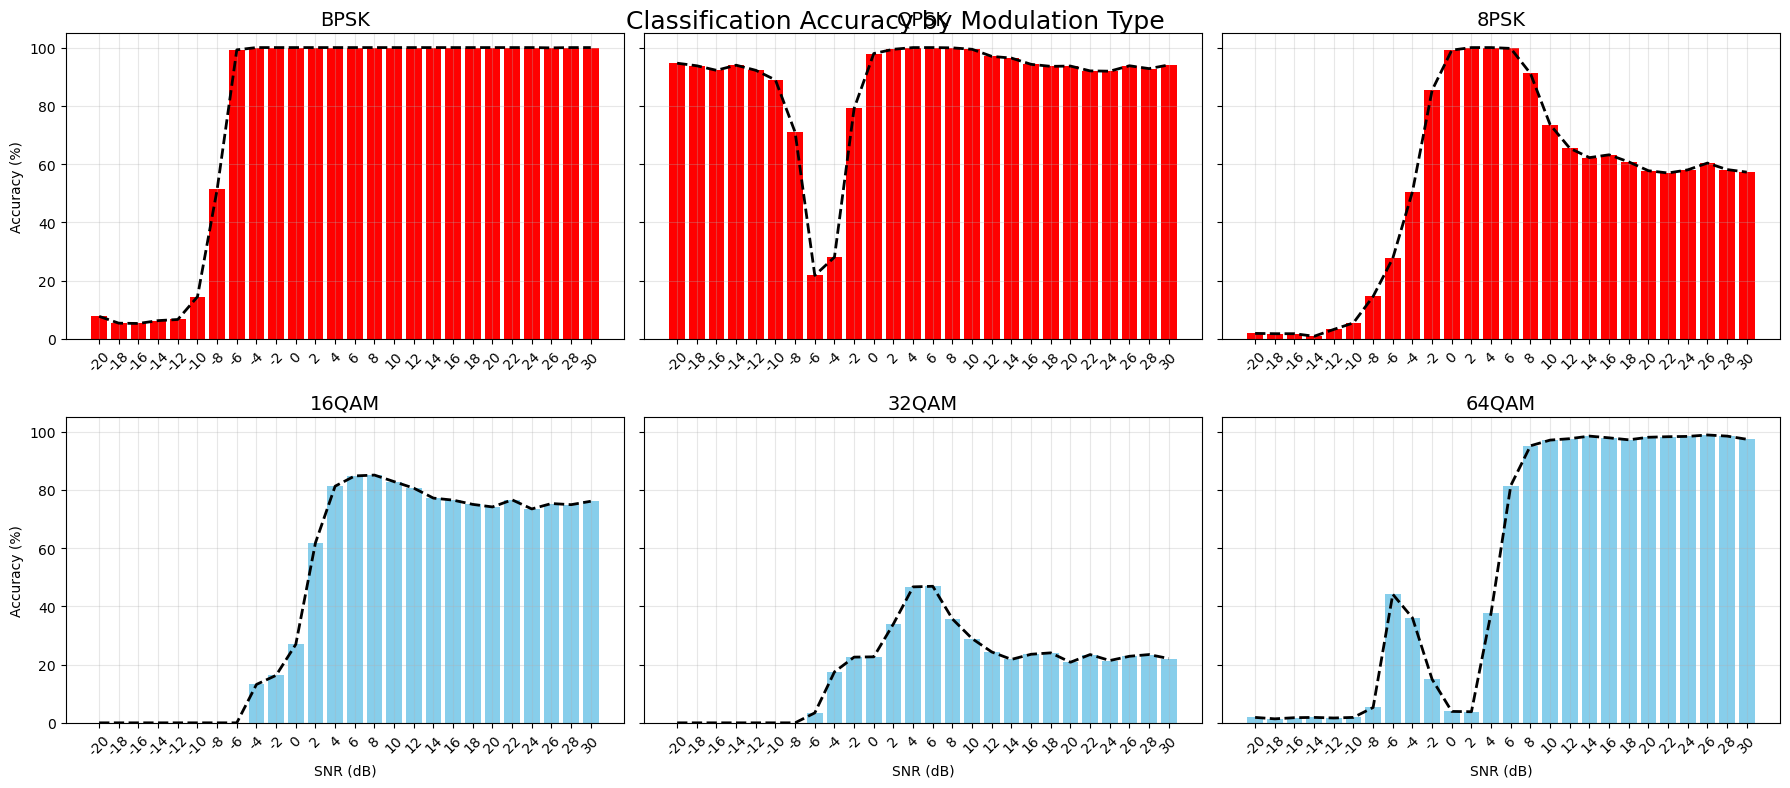

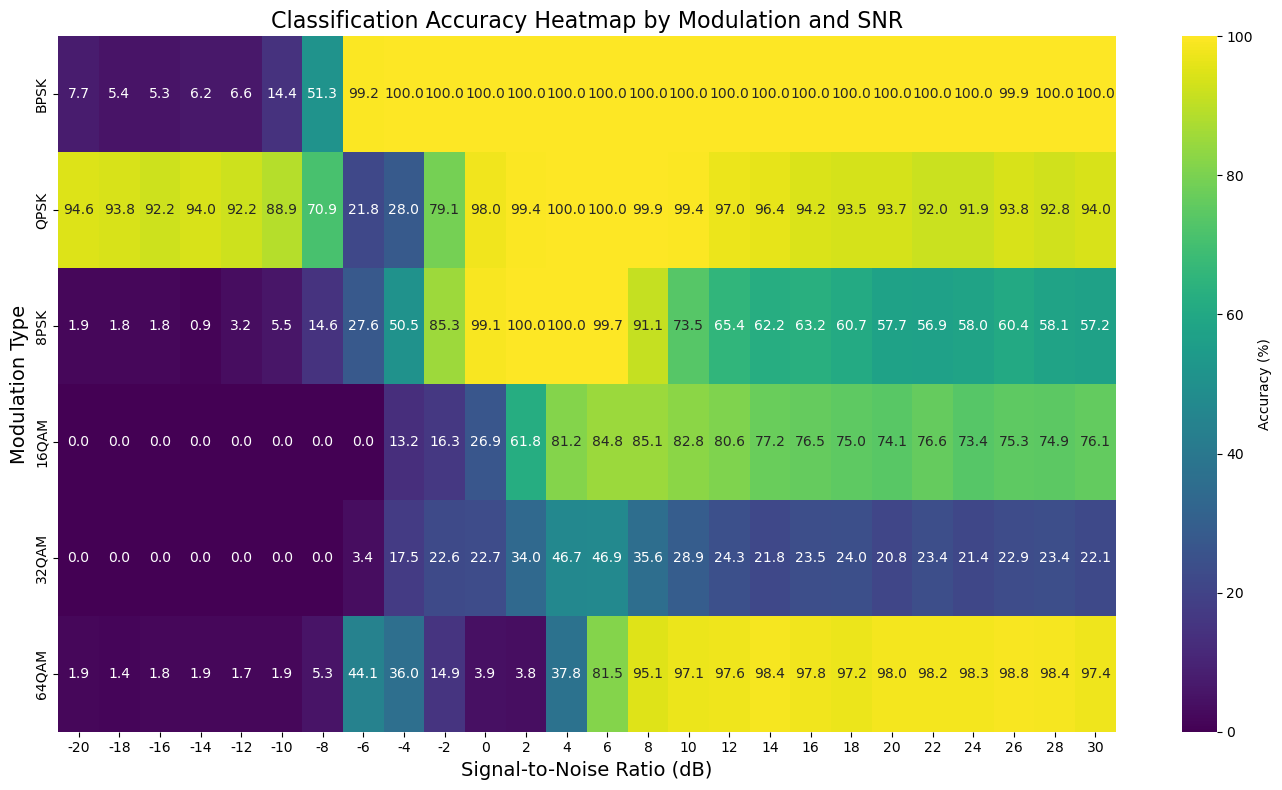

(CNN_NET(
   (backbone): Sequential(
     (0): CNN_Block(
       (block): Sequential(
         (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Dropout(p=0.25, inplace=False)
       )
     )
     (1): CNN_Block(
       (block): Sequential(
         (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Dropout(p=0.25, inplace=False)
       )
     )
     (2): CNN_Block(
       (block): Sequential(
         (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(128, eps=1e-05

In [17]:
improved_train_test_plots(
    model=CNN_NET(n_labels), 
    model_name = 'CNN_NET', 
    device = 'cuda', 
    verbose = True, 
    num_epoch=50
)

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(Y_true, Y_pred, class_names, normalize=True):
    cm = confusion_matrix(Y_true, Y_pred, normalize='true' if normalize else None)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


target modulation:['BPSK', 'QPSK', '8PSK', '16QAM', '32QAM', '64QAM']
target SNR: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]


Testing model: 100%|█| 1248/1248 [00


Accuracy on test dataset: 16.67%
Modulation BPSK: 26624 test samples
Modulation QPSK: 26624 test samples
Modulation 8PSK: 26624 test samples
Modulation 16QAM: 26624 test samples
Modulation 32QAM: 26624 test samples
Modulation 64QAM: 26624 test samples


Calculating per-modulation accuracie


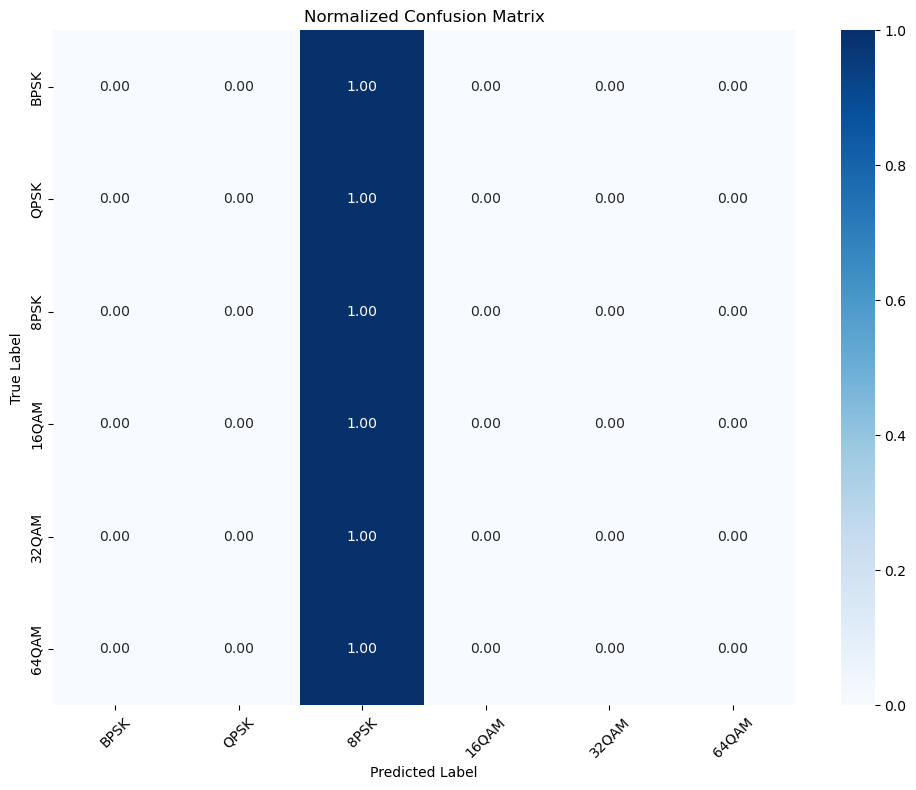

In [21]:
_, _, Y_true, Y_pred = test_model_with_improved_plots(model)
plot_confusion_matrix(Y_true, Y_pred, class_names=test_dl.dataset.target_modulations)

In [23]:
from collections import Counter

label_counts = Counter(dataset.Y_data)
for label, count in label_counts.items():
    mod = dataset.target_modulations[label]
    print(f"{mod}: {count} samples")


BPSK: 26624 samples
QPSK: 26624 samples
8PSK: 26624 samples
16QAM: 26624 samples
32QAM: 26624 samples
64QAM: 26624 samples
